A program to generate option implied stock price prediction surfaces (x = stock price, y = probability density, z = time (days) frome estimation) for many stocks in ane efficient manner. This workbook is comprised of two sections. Section One concerns the extraction and manipulation of the appropriate data. Section Two concerns the creation of the price prediction surfaces. 

**Section One**

---
Defining parameterisable functions to query the OptionMetrics database. Establishing a connection with the WRDS requires credentials, ask your institution for access. The search function runs a parameterisable function to return the required details about each stock on the given day(s). CUSIPS are used as the unqiue identifier for the underlying assests. Due to a paucity of linking variables, the rate lookup must be sequestered to a seperate function.  
 The extracted data is then manipulated to find the days (and portion of a year) left until the expiry of the contract, as well as the mid price from the ask and offer price quoted. 


In [1]:
%pip install wrds # install words package to connect to wrds data service

     |████████████████████████████████| 3.0 MB 14.3 MB/s 


In [2]:
%pip install py_vollib_vectorized # install custom libary to execute numeric BSM calculations on vectors, rather than looping through each row in a dataframe. This is a significant contribution to saving processing power.

     |████████████████████████████████| 130 kB 24.2 MB/s 
  Created wheel for py-vollib: filename=py_vollib-1.0.1-py3-none-any.whl size=62855 sha256=9c74cbc8db565fbb1fd32535b5e2a8057bf2dec5881361269b5b0acd09959862
  Stored in directory: /root/.cache/pip/wheels/2d/25/50/bc80b93c9a827ed9bef9d86f85365e1934bcbc0666b9f00c11
  Created wheel for py-lets-be-rational: filename=py_lets_be_rational-1.0.1-py3-none-any.whl size=24468 sha256=1bf76193f7b9c552099da7f73a1f762aa991c3f51d0fb006727a129f4f52371e
  Stored in directory: /root/.cache/pip/wheels/1a/70/10/bf54a16badc528594c9510ef517badb765a29b651ea5652898
Successfully built py-vollib py-lets-be-rational


In [3]:
import wrds
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import interp1d
import py_vollib.black_scholes
import py_vollib_vectorized
from scipy.interpolate import UnivariateSpline

In [4]:
#  set up the connection to the database
conn = wrds.Connection()

Enter your WRDS username [root]:lmeakin
Enter your password:··········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
Loading library list...
Done


In [5]:
# Set the options to display a full dataframe for inpection (optional)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [47]:
conn.raw_sql("SELECT * FROM optionm.secnmd WHERE ticker = 'QQQ' LIMIT 10")

,secid,effect_date,cusip,ticker,class,issuer,issue,sic
0,107899.0,1999-03-10,63110010,QQQ,None,NASDAQ 100 TR,UNIT SER 1,None
1,107899.0,2000-11-28,63110010,QQQ,None,NASDAQ 100 TR,UNIT SER 1,6726
2,107899.0,2011-03-23,73935A10,QQQ,None,POWERSHARES QQQ TRUST,UNIT SER 1,6726
3,107899.0,2017-12-26,73935A10,QQQ,None,POWERSHARES QQQ TRUST,UNIT SER 1,6733
4,107899.0,2018-06-04,46090E10,QQQ,None,INVESCO CAPITAL MANAGEMENT L,INVESCO QQQ TRUST SE,None


In [9]:
# Search for call options to get date of observation, days left to expiry (t), stock price (S), strike price (K), premium (i.e. price of a call or putt (denoted C/c or P/p)).
#The tables stdopd2020 and secnmd are linked together on 'secid' (OptionMetrics' proporietary underlying id). This is then linked to CRSP's stock price table using CUSIP. 
def search(cusips, date = '2020-01-02', optiontype = '99'):
  """ Return the results of a parameterised WRDS SQL query
  Parameters

  ------------
  tickers: list of strings
    a list of various strings for which to generate options
  date: the date for which option and stock prices are to be generated (i.e. the day for which the analysis will be conducted)
  Returns
  ----------
  A dataframe of options listing the date of capture, the days remaining on the contract, the strike price, the market price of the option, a Call/Put flag, the stock ticker and the underlying (stock) price 
  """
  results = []
  if optiontype == 'C' or optiontype == 'P':
      for item in cusips:
        results.append(
          conn.raw_sql(
              "SELECT a.secid, a.date, a.exdate,  a.cp_flag, a.strike_price, a.best_bid, a.best_offer, a.impl_volatility, b.cusip, c.prc FROM optionm.opprcd2020 a INNER JOIN optionm.secnmd b ON a.secid = b.secid INNER JOIN crsp.dsf c ON b.cusip = c.cusip AND a.date = c.date INNER JOIN optionm.opinfd d ON d.secid = a.secid WHERE a.date = \'" + date + "\' AND b.cusip = \'" + item + "\' AND cp_flag = \'" + optiontype + "\' AND d.exercise_style = 'A' LIMIT 100000000"))
  else:
        for item in cusips:
          results.append(
              conn.raw_sql(
                  "SELECT a.secid, a.date, a.exdate, a.cp_flag, a.strike_price, a.best_bid, a.best_offer, a.impl_volatility,b.cusip, c.prc,  FROM optionm.opprcd2020 a INNER JOIN optionm.secnmd b ON a.secid = b.secid INNER JOIN crsp.dsf c ON b.cusip = c.cusip AND a.date = c.date INNER JOIN optionm.opinfd d ON d.secid = a.secid WHERE a.date = \'" + date + "\' AND b.cusip = \'" + item + "\' AND d.exercise_style = 'A' LIMIT 10000000000"))
  return results

In [5]:
# function to find correct interest rate
# takes the details required to find the correct risk free rate rate (i.e. currency, date and time period) chooses the time period closest to those listed
def rate_lookup(date = '2020-01-02', days = '100', currency = '333'):
  return conn.raw_sql("SELECT rate FROM optionm.zero_curve WHERE date = \'" + str(date) + "\' AND currency = \'" + currency + "\' ORDER BY (ABS(days - \'" + str(days) + "\')) ASC LIMIT 1").rate # the period of time (days) which is closest to those quoted in the zero-curve is chosen (the rate yeilded is an anualised, continuosly compunded value)
#rate_lookup()

In [48]:
# upload list of CUSIPS (unique security identifier)
cusips = ['12476510', '74144T10', '93114210', '94974610', '03783310', '47816010', '45920010', '46090E10'] # Ths could be from a list uploaded from a .csv file. See SEC or Bloomberg for the CUSIPS of the stocks of interest.
#cusips = ['12476510', '74144T10']

In [49]:
data = search(cusips, optiontype = 'C') # run a search for stocks based on the list 'cusips' above. This produces n query results
for dfs in data:
  dfs['d'] = (dfs.exdate - dfs.date).dt.days # for each stock convert the time until expiry of it's contracts to days
  dfs['t'] = ((dfs.exdate - dfs.date).dt.days)/365.2525 # annualise these days to years
  dfs['mid_price'] = (dfs.best_offer.values + dfs.best_bid.values)/2 # compute the mid price of the bid offers for the contract
  #print(dfs.cusip[0])
  #dfs['rate'] = np.vectorize(rate_lookup)(dfs.date.values, dfs.d.values) # look up the correct risk free rate for the date and time period. See if this can be run faster, as currently it has to run a new SQL query for each row in each dataframe in the list
#data[0].drop_duplicates()

12476510
74144T10
93114210
94974610
03783310
47816010
45920010
46090E10


**Section Two**  

---


  
Using Breeden-Litzenburger:

  
Although problematic, the paradeigmatic Black-Scholes-Merton forumlae are used to translate the options into strike-price - implied volatility space for smoother interpolation. BSM is then applied again to turn these interpolated valued into a smooth strike-price call-(or put) price function.

Recall BSM:  
  
$\Large C = N(d_1)S - N(d_2)Ke^{-rt}$   
$\Large P = -N(-d_1)S + N(-d_2)ke^{-rt} $ , 

where    
  
$d_1 =\frac{1}{\sigma \sqrt{t}}[\ln\frac{S}{K} + (r + \frac{\sigma^2}{2})t] $  
$\Large d_2 = d_1 - \sigma \sqrt{t}$

The numerical calculation of IVs and call(-or put prices) is handeled by the py_volib libaray.

The Breeden-Litzenburger formula is then applied to generate a probability denisty function for each underlying asset at many points into the future.
 
Recall Breeden-Litzenburger: there is a one-to-one relations between option prices and risk-neutral distribution.  
$\Large\frac{\delta c(X)}{\delta X} = -e^{-rT} \int_{K}^{\infty} f(S_t)dS_T$   
   
$\Large\frac{\delta ^2 C}{\delta K^2} = e^{-r \tau} f(X) $

This code yeilds a prediction surface (i.e. muliple probability density functions populating the x and y-axes (x: stock price, y:probability density) with time to expiry on the z-axis) for every stock considered, starting at the initial given observation date and moving through time.

In [50]:
def get_stocks_PDFs(dataset):
  groupedivs = dataset.drop_duplicates().sort_values('strike_price').groupby(["date", "d", "cp_flag", "cusip"]) # to reduce the number of times the computationally expensive rate_lookup function is called rows are sorted by date and days to expiry. The risk-free rate which is found is then replacated for each options over the same time period.
  frames = {}
  for key, item in groupedivs:
    item.dropna(inplace=True)
    item.reset_index(drop=True, inplace=True)
    f2 = UnivariateSpline(item['strike_price']/1000, item['impl_volatility'], k=3) # a cubic univariate spline is used to interpolate in strike-price - implied volatility space
    xnew = np.linspace(item['strike_price'].min()/1000, item['strike_price'].max()/1000, num=1000, endpoint=True) # 1000 strike prices are then used to generate a smooth strike-price, call (or put) price function. This is required as the strike prices of the contracts available on the market are disjoint (i.e. $50, $55, $60 etc.)
    r = rate_lookup(days = item.d[0]).values
    t = item.t[0]
    c_prices = py_vollib.black_scholes.black_scholes(item.cp_flag.str.lower()[0], item.prc[0], xnew, t, r, f2(xnew), return_as='numpy') # the required smooth strike-price - call-price function is then generate by the reapplication of BSM to yeild call prices for the respective S, rf, d, k combinations 
    first_deriv = np.gradient(c_prices, xnew)
    second_deriv = np.gradient(first_deriv, xnew)
    curve = np.exp(r * t) * second_deriv  # create the PDF
    prediction = pd.DataFrame(curve, xnew)
    print(prediction) # print a diagnostic plot (i.e. show the curves as they are being plotted) # Note: this will become less and less intelligable as the number of stocks plotted on the same axes increases
    plt.plot(xnew, curve)
    frames[key] = prediction
  return frames

                  0
17.500000  0.023705
17.522523  0.035588
17.545045  0.047531
17.567568  0.047652
17.590090  0.047770
...             ...
39.909910 -0.010191
39.932432 -0.010225
39.954955 -0.010258
39.977477 -0.007710
40.000000 -0.005146

[1000 rows x 1 columns]
                 0
15.00000 -0.005797
15.02002 -0.008686
15.04004 -0.011557
15.06006 -0.011520
15.08008 -0.011482
...            ...
34.91992  0.046677
34.93994  0.047071
34.95996  0.047467
34.97998  0.035798
35.00000  0.023932

[1000 rows x 1 columns]
                  0
17.500000  0.002266
17.522523  0.003401
17.545045  0.004540
17.567568  0.004548
17.590090  0.004556
...             ...
39.909910  0.000057
39.932432  0.000042
39.954955  0.000027
39.977477  0.000012
40.000000  0.000006

[1000 rows x 1 columns]
                 0
15.00000  0.003181
15.02002  0.004771
15.04004  0.006362
15.06006  0.006361
15.08008  0.006361
...            ...
34.91992  0.006563
34.93994  0.006509
34.95996  0.006455
34.97998  0.004815
35.00000

{(datetime.date(2020, 1, 2), 1, 'C', '74144T10'):                    0
 124.000000  0.196148
 124.017017  0.297142
 124.034034  0.403896
 124.051051  0.415248
 124.068068  0.426250
 ...              ...
 140.931932 -0.012296
 140.948949 -0.012308
 140.965966 -0.012320
 140.982983 -0.009246
 141.000000 -0.006166
 
 [1000 rows x 1 columns],
 (datetime.date(2020, 1, 2), 8, 'C', '74144T10'):                    0
 115.000000  0.017283
 115.025025  0.025875
 115.050050  0.034367
 115.075075  0.034168
 115.100100  0.033969
 ...              ...
 139.899900 -0.007353
 139.924925 -0.007385
 139.949950 -0.007418
 139.974975 -0.005580
 140.000000 -0.003725
 
 [1000 rows x 1 columns],
 (datetime.date(2020, 1, 2), 15, 'C', '74144T10'):                   0
 100.00000  0.000137
 100.05005  0.000206
 100.10010  0.000275
 100.15015  0.000275
 100.20020  0.000275
 ...             ...
 149.79980  0.006669
 149.84985  0.006697
 149.89990  0.006724
 149.94995  0.005057
 150.00000  0.003376
 
 [1000 rows x 

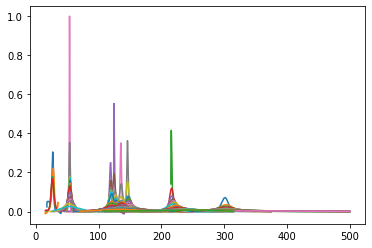

In [51]:
all_results = []
for item in data:
  all_results.append(get_stocks_PDFs(item))
all_results[1]